In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout

In [2]:
def create_sequences(df, target_col, window_size=24):
    """
    df: DataFrame with all numeric columns, including target_col
    window_size: number of timesteps in each input sequence
    """
    data = df.values
    X_list, y_list = [], []
    
    for i in range(len(data) - window_size):
        X_list.append(data[i : i + window_size])
        y_list.append(data[i + window_size, target_col])
    
    X_arr = np.array(X_list)
    y_arr = np.array(y_list)
    return X_arr, y_arr

In [3]:
# 1. Load the dataset
df   = pd.read_csv('/kaggle/input/delhi-air-quality/delhi_aqi.csv', parse_dates=True)
df  

,date,co,no,no2,o3,so2,pm2_5,pm10,nh3
0,2020-11-25 01:00:00,2616.88,2.18,70.60,13.59,38.62,364.61,411.73,28.63
1,2020-11-25 02:00:00,3631.59,23.25,89.11,0.33,54.36,420.96,486.21,41.04
2,2020-11-25 03:00:00,4539.49,52.75,100.08,1.11,68.67,463.68,541.95,49.14
3,2020-11-25 04:00:00,4539.49,50.96,111.04,6.44,78.20,454.81,534.00,48.13
4,2020-11-25 05:00:00,4379.27,42.92,117.90,17.17,87.74,448.14,529.19,46.61
...,...,...,...,...,...,...,...,...,...
18771,2023-01-24 04:00:00,1762.39,4.64,37.01,33.26,30.52,231.15,289.84,6.27
18772,2023-01-24 05:00:00,1735.69,6.82,34.96,46.49,34.33,225.08,280.52,9.12
18773,2023-01-24 06:00:00,1922.61,8.16,40.10,56.51,43.39,242.49,296.07,12.54
18774,2023-01-24 07:00:00,1361.85,9.05,52.78,71.53,100.14,165.67,191.82,7.47


In [4]:
# Convert datetime column if present
if 'date' in df.columns:  # Change 'date' to the actual column name
    df['date'] = pd.to_datetime(df['date'])  # Convert to datetime
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['hour'] = df['date'].dt.hour
    df.drop(['date'], axis=1, inplace=True)  # Drop original datetime column

# Drop any remaining non-numeric columns
df = df.select_dtypes(include=[np.number])

In [5]:
# 2. Prepare features and target
# Assume 'pm2_5' is the target variable, and the rest are features.
target_col_idx = df.columns.get_loc('pm2_5')
window_size = 24  # last 24 hours as input

X, y = create_sequences(df, target_col_idx, window_size=window_size)

In [6]:
# Train/Test split
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [7]:
# Scale
scaler = StandardScaler()
# Reshape X for scaling (samples * timesteps, features)
num_features = X.shape[2]
X_train_2d = X_train.reshape(-1, num_features)
X_test_2d = X_test.reshape(-1, num_features)

X_train_2d_scaled = scaler.fit_transform(X_train_2d)
X_test_2d_scaled = scaler.transform(X_test_2d)

# Reshape back to 3D
X_train_scaled = X_train_2d_scaled.reshape(X_train.shape[0], window_size, num_features)
X_test_scaled = X_test_2d_scaled.reshape(X_test.shape[0], window_size, num_features)

In [8]:

# Build CNN-LSTM model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size, num_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 22, 64)              │           2,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 11, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 11, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37,505 (146.50 KB)

 Trainable params: 37,505 (146.50 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [10]:
# Train
history = model.fit(X_train_scaled, y_train, 
                    epochs=50, 
                    batch_size=32, 
                    validation_split=0.1,
                    callbacks=[early_stop])

Epoch 1/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 89796.8594 - val_loss: 3153.6455
Epoch 2/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 19669.5293 - val_loss: 1824.0239
Epoch 3/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 7625.5278 - val_loss: 1271.8931
Epoch 4/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 4666.4146 - val_loss: 1109.5465
Epoch 5/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 4153.8252 - val_loss: 1159.3285
Epoch 6/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 3627.9294 - val_loss: 1141.1243
Epoch 7/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 3716.7627 - val_loss: 1107.1545
Epoch 8/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 3223.5049 - val_loss: 952.0491
Epoch 9/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 2942.7661 - val_loss: 935.2632
Epoch 10/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 3046.5735 - val_loss: 1049.2678
Epoch 11/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 2601.74

In [12]:
# Evaluate
y_pred = model.predict(X_test_scaled).ravel()
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)

print("MSE: ", mse)
print("MAE: ", mae)
print("R2: ", r2)

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
MSE:  2649.291095150885
MAE:  34.4023452060733
R2:  0.9488223704358851


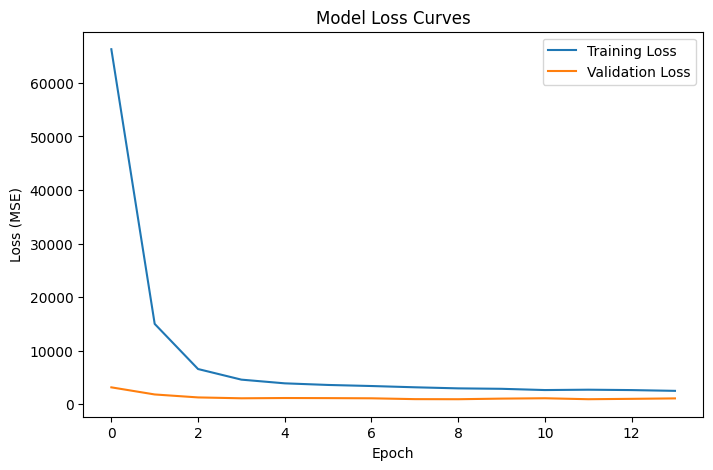

In [13]:
# 9. Plot loss curves for training and validation loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

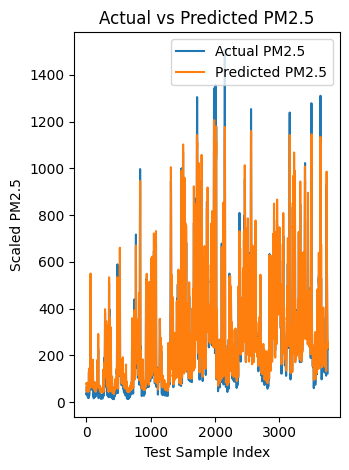

In [14]:
# Plot actual vs predicted on the test set
plt.subplot(1, 2, 2)
plt.plot(y_test, label='Actual PM2.5')
plt.plot(y_pred, label='Predicted PM2.5')
plt.title('Actual vs Predicted PM2.5')
plt.xlabel('Test Sample Index')
plt.ylabel('Scaled PM2.5')
plt.legend()

plt.tight_layout()
plt.show()